In [1]:
push!(LOAD_PATH, "/Users/jayyao/Documents/Research/TraceFormula/Module")
using GridapEM
using Gridap
using DelimitedFiles
using KrylovKit
using LinearAlgebra
using GridapMakie
using GLMakie

┌ Info: Precompiling GridapEM [top-level]
└ @ Base loading.jl:1342


In [2]:
include("/Users/jayyao/Documents/Research/TraceFormula/Module/DefaultParameters.jl")

# Change default geometry parameters
rd = 0.5 #/ sqrt(2)
rt = rd + 0.2
resol = 40.0      # Number of points per wavelength
l1 = λ/resol      # Normal region
l2 = l1/2.0       # Design region
l3 = 2*l1         # PML

# Create mesh file
geo_param = CirRecGeometry(L, H, rd, rt, dpml, l1, l2, l3)
#geo_param = PeriodicGeometry(L, h1, h2, h3, ht, hs, dpml, l1, l2, l3)
meshfile_name = "geometry.msh"
#MeshGenerator(geo_param, meshfile_name)

# Apply gridap finite element analysis to mesh file
gridap = GridapFE(meshfile_name, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], [], flag_f)
#run(`gmsh geometry.msh`)

# Change default physics parameters
kb = VectorValue(2*π*0.,0)
LHp=[L / 2, H / 2]  # Start of PML for x,y > 0
LHn=[L / 2, H / 2]  # Start of PML for x,y < 0

phys = PhysicalParameters(k, kb, ω, ϵ1, ϵ2, ϵ3, ϵd, μ, R, σs, dpml, LHp, LHn, wg_center, wg_size)

# Change default control parameters
Bρ = true
ρv = 0.5
β = 80.0
K = 5
control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bρ, ρv, c, ηe, ηd)


Info    : Reading 'geometry.msh'...
Info    : 60 entities
Info    : 23242 nodes
Info    : 46924 elements
Info    : Done reading 'geometry.msh'


ControllingParameters(true, true, [0.02, 0.02], 80.0, 0.5, 0.0005, 15, 30, 5, 1.0, true, 0.5, 0.0, 0.75, 0.25)

In [19]:
ρ_circ(x, r) = (x[1]^2 + x[2]^2) < r^2 ? 1 : 0
r_init = (0.5 - 0.5 / sqrt(2)) * 0.0 + 0.5 / sqrt(2)
lc_temp(v) = ∫(v * x->ρ_circ(x, r_init))gridap.dΩ
ρc_vec = assemble_vector(lc_temp, gridap.FE_P)
ρ_init = ρ_extract(ρc_vec; gridap)
#ρ_init[ρ_init .< 0.5] .= 0
ρ_init[ρ_init .> 0] .= 1#(0.5 / r_init)^2 /2
sum(ρ_init) / gridap.np, maximum(ρ_init)

(0.5038193855033102, 1.0)

In [ ]:
ρ_init = Interpolated_Initial_Guess(gridap)
ρf_vec = ρf_ρ0(ρ_init; control, gridap)
ρfh = FEFunction(gridap.FE_Pf, ρf_vec)
ρth = (ρf -> Threshold(ρf; control)) ∘ ρfh
fig, ax, plt = plot(gridap.Ω, ρth, colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(H))
ax.title = "ε"
limits!(ax, -L/2, L/2, -phys.LHn[2], phys.LHp[2])
fig

In [17]:
#ρ_init = ones(gridap.np) * 0.45
#ρW_temp = readdlm("ρW_opt_value.txt", Float64)
#ρW_temp = ρW_temp[:]
#ρ_init = ρW_temp[1 : gridap.np]
#ρ_init[ρ_init .< 0.5] .= 0
#ρ_init[ρ_init .>= 0.5] .= 1.0
#r = [0.02 * λ, 0.02 * λ]  # Filter radius
Q_list = [20, 50, 100, 500, 1000, 1000, 1000]
#Q_list = [1000, 1000, 1000, 1000, 1000]
#β_list = [5.0, 10.0, 10.0, 40.0, 80.0, 80.0, 80.0]
β_list = [5.0, 10.0, 20.0, 30.0, 40.0, 60.0, 80.0]

g_opt = 0
for bi = 1 : 1
    β = β_list[bi]
    α = 1.0 / (2 * Q_list[bi])
    K = 5
    phys = PhysicalParameters(k, kb, ω, ϵ1, ϵ2, ϵ3, ϵd, μ, R, σs, dpml, LHp, LHn, wg_center, wg_size)
    control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bρ, ρv, c, ηe, ηd)

    if bi == 1
        g_opt, ρW_opt = gρW_optimize(ρ_init, 1e-6, 200, :LD_MMA; phys,control, gridap)
    else
        g_opt, ρW_opt = gρW_optimize([], 1e-6, 200, :LD_CCSAQ; phys, control, gridap)
    end
    if isfile("ρW_opt.value.txt")
        run(`rm ρW_opt_value.txt`)
    end
    open("ρW_opt_value.txt", "w") do iop
        for i = 1 : length(ρW_opt)
            ρW_temp = ρW_opt[i]
            write(iop, "$ρW_temp \n")
        end
    end
    open("g_opt_value.txt", "a") do io
        write(io, "$g_opt \n")
    end
end
@show g_opt

numevals = opt.numevals = 50
g_opt = 46.25584812494963


46.25584812494963

sum(∫(ρth) * gridap.dΩ_d) / sum(∫(1) * gridap.dΩ_d) = 0.45391502998772304


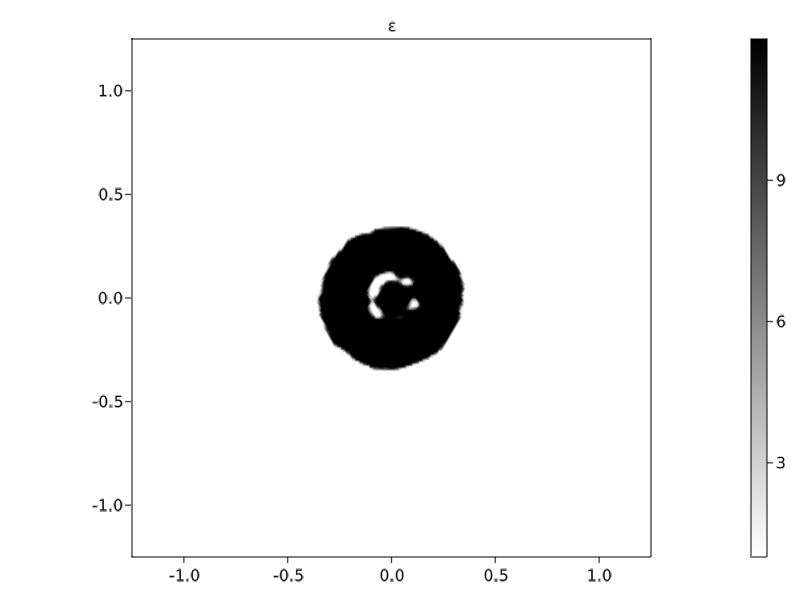

In [18]:
# Output and view
ImportFromFile = true
N = num_free_dofs(gridap.FE_U)
if ImportFromFile
    ρW_max = readdlm("ρW_opt_value.txt", Float64)
    ρW_max = ρW_max[:]
    ρ0 = ρW_max[1 : gridap.np]
    W_mat = reinterpret(ComplexF64, reshape(ρW_max[gridap.np + 1 : end], (2 * N, control.K)))
else
    ρ0 = ones(gridap.np)
end
 
ρf_vec = ρf_ρ0(ρ0; control, gridap)
ρfh = FEFunction(gridap.FE_Pf, ρf_vec)
ρth = (ρf -> Threshold(ρf; control)) ∘ ρfh
        
A_mat = MatrixA(ρth; phys, control, gridap)
B_mat = MatrixB(ρth; control, gridap)
@show sum(∫(ρth)gridap.dΩ_d) / sum(∫(1)gridap.dΩ_d)

A0_mat = MatrixA0(phys, control, gridap)
O_mat = MatrixOc(phys.k, phys.ϵ1; gridap)

G_ii, V_raw, info = eigsolve(x -> A_mat \ (A0_mat * x), rand(ComplexF64, N), 10, :LM)
G_trace, W_raw, info = eigsolve(x -> MatrixG(x; A_mat, B_mat, O_mat), rand(ComplexF64, N), control.K, :LM; krylovdim = 30)
if !ImportFromFile
    W_mat = rand(ComplexF64, N, control.K)
    for ib = 1 : control.K
        W_mat[:, ib] = W_raw[ib]
    end
end


V_mat = rand(ComplexF64, N, control.K)
for ib = 1 : control.K
    V_mat[:, ib] = V_raw[ib]
end
U_mat = A_mat \ (B_mat * W_mat)
uh_eig = FEFunction(gridap.FE_U, V_mat[:, 1])
uh = FEFunction(gridap.FE_U, U_mat[:, 1])

fig, ax, plt = plot(gridap.Ω, real(1 + 11 * ρth), colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(H))
ax.title = "ε"
limits!(ax, -L/2, L/2, -phys.LHn[2], phys.LHp[2])
save("Results/shape.png", fig)
fig

In [ ]:
x_eig = W_mat[:, 1]
g_trace = x_eig' * MatrixG(x_eig; A_mat, B_mat, O_mat) / (x_eig' * x_eig)
abs(g_trace)

In [ ]:
(abs.(G_trace))

In [ ]:
# r = 0.5 uniform g = 13.301107377129648
# 167.30018269788212 12.577913849905718
sum(abs.(G_trace)), g_ρ(ρ0; O_mat, W_mat, phys, control, gridap)

In [ ]:
uh = FEFunction(gridap.FE_U, B_mat * U_mat[:, 5])
fig1, ax1, plt1 = plot(gridap.Ω, imag(uh), colormap = :bwr)
Colorbar(fig1[1,2], plt1)
ax1.aspect = AxisAspect(L/(H))
ax1.title = "real(Hz)"
limits!(ax1, -L/2, L/2, -phys.LHn[2], phys.LHp[2])
fig1

In [ ]:
uh_eig = FEFunction(gridap.FE_U, V_mat[:, 3])
uh = FEFunction(gridap.FE_U, U_mat[:, 1])
fig1, ax1, plt1 = plot(gridap.Ω, real(uh), colormap = :bwr)
Colorbar(fig1[1,2], plt1)
ax1.aspect = AxisAspect(L/(H))
ax1.title = "real(Hz)"
limits!(ax1, -L/2, L/2, -phys.LHn[2], phys.LHp[2])
save("Results/s_mode_2.png", fig1)
fig2, ax2, plt2 = plot(gridap.Ω, real(uh_eig), colormap = :bwr)
Colorbar(fig2[1,2], plt2)
ax2.aspect = AxisAspect(L/(H))
ax2.title = "real(Hz)"
limits!(ax2, -L/2, L/2, -phys.LHn[2], phys.LHp[2])
save("Results/t_mode_2.png", fig2)
fig1


In [ ]:
fig2

In [ ]:

g_values = open(readdlm,"gvalue.txt")
#g_values = open(readdlm,"Results/L0.6_0.05_1.2.txt")
GLMakie.scatter(range(1, length(g_values[:]), step=1), g_values[:], markersize = 2)


In [ ]:
N = num_free_dofs(gridap.FE_U)
ρW0 = rand(gridap.np + 2 * N * control.K) * 1
δρW = rand(gridap.np + 2 * N * control.K) * 1e-6

O_mat = MatrixOc(phys.ω, phys.ϵ1; gridap)

grad = zeros(gridap.np + 2 * N * control.K)
g1 = g_ρW(ρW0 + δρW, []; O_mat, phys, control, gridap)
g0 = g_ρW(ρW0, grad; O_mat, phys, control, gridap)
g1 - g0, grad' * δρW

In [10]:
grad_max = zeros(gridap.np + 2 * N * control.K)
g0 = g_ρW(ρW_max, grad_max; O_mat, phys, control, gridap)
norm(grad_max), g0

2.963748807631573

In [16]:
α_step = 0.02
g_ρW(ρW_max+grad_max*α_step, []; O_mat, phys, control, gridap)-g0

0.09229749263983678

In [ ]:
grad = zeros(gridap.np + 2 * N * control.K)
δρW = rand(gridap.np + 2 * N * control.K) * 1e-6
g1 = g_ρW(ρW_max+ δρW, []; O_mat, phys, control, gridap)
g0 = g_ρW(ρW_max, grad; O_mat, phys, control, gridap)
g1 - g0, grad' * δρW

In [ ]:
g0